#### 1. Generate Low-energy 3D conformers from SMILES/ SDF using Auto3D and AIMNet2 Neural Network Potential



In [ ]:
import os, sys
import Auto3D
from Auto3D.auto3D import options, main
from Auto3D.ASE.geometry import opt_geometry
from Auto3D.SPE import calc_spe


if __name__ == "__main__":
    path= "/projects/bbjt/icho1/Global_min/jacs_set_smi/bace/DACON.smi"
    #args = options(path, k=1, use_gpu=True, opt_steps=5000,convergence_threshold=0.001,patience=2000,max_confs=5000,job_name="v1")   #specify the parameters for Auto3D
    args = options(path, k=1, use_gpu=True)
    out = main(args) 

#### 2. Use LEFTNet architecture to predict IC50 prediction of IRAK4

In [3]:
import os
os.chdir('/mnt/c/Users/user/Desktop/DACON/LeftNet')
# from qm9_dataset import QM93D
from model import LEFTNet
import argparse
import os
import torch
from torch.optim import Adam
from torch_geometric.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, OneCycleLR, CosineAnnealingWarmRestarts
from tqdm import tqdm
import time

In [ ]:
from rdkit import Chem
import pandas as pd
import torch
from torch_geometric.data import Data
from tqdm import tqdm
import numpy as np

# Load the SDF file
# suppl = Chem.SDMolSupplier('/mnt/c/Users/user/Desktop/DACON/bace2/DACON_test_out.sdf', removeHs=False, sanitize=False)
suppl = Chem.SDMolSupplier('/mnt/c/Users/user/Desktop/DACON/bace2/DACON_out.sdf', removeHs=False, sanitize=False)

csv_file = '/mnt/c/Users/user/Desktop/DACON/train.csv'
df = pd.read_csv(csv_file)

data_list = []

for i, mol in enumerate(tqdm(suppl)):
    if mol is None:
        continue  # Skip if molecule is None (corrupted or unreadable entry)
    
    # Extract the _id from the molecule
    _id = mol.GetProp('_Name')  # Adjust this line based on where the ID is stored

    # Get the corresponding IC50_nm value from the CSV file
    # ic50_value = df[df['Molecule ChEMBL ID'] == _id]['IC50_nM'].values
    # ic50_value=0
    ic50_value = df[df['Molecule ChEMBL ID'] == _id]['pIC50'].values
    
    # If there's a matching entry, assign the value to y
    
    # y = torch.tensor(float('nan'))  # Handle cases where there's no matching entry
    
    if len(ic50_value) > 0:
        y = torch.tensor(ic50_value[0], dtype=torch.float)
    else:
        y = torch.tensor(float('nan'))  # Handle cases where there's no matching entry
    # Get molecular conformer and positions
    
    conf = mol.GetConformer()
    pos = conf.GetPositions()
    pos = torch.tensor(pos, dtype=torch.float)
    posc = pos - pos.mean(dim=0)  # Center positions around their mean

    # Get atomic numbers
    atomic_number = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    z = torch.tensor(atomic_number, dtype=torch.long)

    # Create Data object and append to the list
    data = Data(
        z=z,
        pos=pos,
        posc=posc,
        y=y
    )
    data_list.append(data)

In [ ]:
from torch_geometric.data import InMemoryDataset, DataLoader

data, slices = InMemoryDataset.collate(data_list)

print('Saving...')
torch.save((data, slices), 'DACON22.pt')

In [4]:
import os
# os.chdir('/mnt/c/Users/user/Desktop/DACON/LeftNet')
# from qm9_dataset import QM93D
from model import LEFTNet
import argparse
import os
import torch
from torch.optim import Adam
from torch_geometric.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, OneCycleLR, CosineAnnealingWarmRestarts
from tqdm import tqdm
import time

import torch
from torch_geometric.data import InMemoryDataset, DataLoader
from torch.utils.data import Subset
# from torch_geometric.data import DataLoader as GeoDataLoader
from sklearn.utils import shuffle

class CustomDataset(InMemoryDataset):
    def __init__(self, path):
        super().__init__(path)
        self.data, self.slices = torch.load(path)
    
    def get_idx_split(self, data_size, train_size, valid_size, seed):
        ids = shuffle(range(data_size), random_state=seed)
        train_idx = torch.tensor(ids[:train_size])
        val_idx = torch.tensor(ids[train_size:train_size + valid_size])
        test_idx = torch.tensor(ids[train_size + valid_size:])
        return {'train': train_idx, 'valid': val_idx, 'test': test_idx}


# Path to your .pt file
pt_file_path = '/mnt/c/Users/user/Desktop/DACON/LeftNet/temp/DACON2.pt'
# pt_file_path = '/mnt/c/Users/user/Desktop/DACON/aimnet2/submission_DACON/leftnet_diffdock_600.pt'


# Create the dataset
dataset = CustomDataset(pt_file_path)


data_size = len(dataset)
train_size = int(0.8 * data_size)  # 80% for training
valid_size = int(0.1 * data_size)  # 10% for validation
test_size = data_size - train_size - valid_size  # 10% for testing
split_dict = dataset.get_idx_split(data_size, train_size, valid_size, seed=42)

train_dataset = Subset(dataset, split_dict['train'])
valid_dataset = Subset(dataset, split_dict['valid'])
test_dataset = Subset(dataset, split_dict['test'])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# y_mean = torch.mean(dataset.data.y).item()
# y_std = torch.std(dataset.data.y).item()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader2 = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader2 = DataLoader(valid_dataset, batch_size=64, shuffle=False)

train_data = next(iter(train_loader2))
y_train = train_data.y

y_mean = torch.mean(y_train).item()
y_std = torch.std(y_train).item()

device='cpu'
model = LEFTNet(pos_require_grad=False, cutoff=5, num_layers=4,
            hidden_channels=256, num_radial=32, y_mean=y_mean, y_std=y_std)


# model = LEFTNet(pos_require_grad=False, cutoff=8, num_layers=6,
#             hidden_channels=256, num_radial=96, y_mean=y_mean, y_std=y_std)

model = model.to(device)
loss_func = torch.nn.L1Loss()

optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=0)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)
scheduler_name="steplr"

save_dir='models/'
log_dir=''

if save_dir != '':
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
if log_dir != '':
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir=log_dir)

/home/ilkwon/anaconda3/envs/Comp_lecture/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/ilkwon/anaconda3/envs/Comp_lecture/lib/python3.10/site-packages/torch_geometric/nn/conv/message_passing.py:972: UserWarning: 'EquiMessagePassing.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "


In [27]:
# from qm9_dataset import QM93D
from model import LEFTNet
import argparse
import os
import torch
from torch.optim import Adam
from torch_geometric.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, OneCycleLR, CosineAnnealingWarmRestarts
from tqdm import tqdm
import time

import torch
from torch_geometric.data import InMemoryDataset, DataLoader
from torch.utils.data import Subset
# from torch_geometric.data import DataLoader as GeoDataLoader
from sklearn.utils import shuffle

class CustomDataset(InMemoryDataset):
    def __init__(self, path):
        super().__init__(path)
        self.data, self.slices = torch.load(path)
    
    def get_idx_split(self, data_size, train_size, valid_size, seed):
        ids = shuffle(range(data_size), random_state=seed)
        train_idx = torch.tensor(ids[:train_size])
        val_idx = torch.tensor(ids[train_size:train_size + valid_size])
        test_idx = torch.tensor(ids[train_size + valid_size:])
        return {'train': train_idx, 'valid': val_idx, 'test': test_idx}

# Path to your .pt file
# pt_file_path = '/mnt/c/Users/user/Desktop/DACON/LeftNet/temp/'
pt_file_path = '/mnt/c/Users/user/Desktop/DACON/LeftNet/temp/DACON22.pt'


# Create the dataset
dataset = CustomDataset(pt_file_path)

data_size = len(dataset)
train_size = int(0.8 * data_size)  # 80% for training
valid_size = int(0.1 * data_size)  # 10% for validation
test_size = data_size - train_size - valid_size  # 10% for testing
split_dict = dataset.get_idx_split(data_size, train_size, valid_size, seed=42)

train_dataset = Subset(dataset, split_dict['train'])
valid_dataset = Subset(dataset, split_dict['valid'])
test_dataset = Subset(dataset, split_dict['test'])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# y_mean = torch.mean(dataset.data.y).item()
# y_std = torch.std(dataset.data.y).item()

train_data = next(iter(train_loader))
y_train = train_data.y

y_mean = torch.mean(y_train).item()
y_std = torch.std(y_train).item()

model = LEFTNet(pos_require_grad=False, cutoff=5, num_layers=4,
            hidden_channels=256, num_radial=32, y_mean=y_mean, y_std=y_std)

# model = LEFTNet(pos_require_grad=False, cutoff=8, num_layers=6,
#             hidden_channels=256, num_radial=96, y_mean=y_mean, y_std=y_std)

model = model.to(device)
loss_func = torch.nn.L1Loss()

optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=0)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)
scheduler_name="steplr"

save_dir='models/'
log_dir=''

if save_dir != '':
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
if log_dir != '':
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir=log_dir)

/home/ilkwon/anaconda3/envs/Comp_lecture/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/tmp/ipykernel_2707/409880191.py:60: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847130/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  y_std = torch.std(y_train).item()
/home/ilkwon/anaconda3/envs/Comp_lecture/lib/python3.10/site-packages/torch_geometric/nn/conv/message_passing.py:972: UserWarning: 'EquiMessagePassing.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "


=====Epoch 1


100%|██████████| 196/196 [00:02<00:00, 75.98it/s]


Saving checkpoint...
{'Train': 2.4964990780798004, 'Validation': 0.8613350987434387, 'Test': 0.7943372130393982, 'Best valid': 0.8613350987434387, 'Test@ best valid': 0.7943372130393982, 'Duration': 60.057509796999966}
=====Epoch 2


100%|██████████| 196/196 [00:02<00:00, 73.06it/s]


Saving checkpoint...
{'Train': 1.0150872132168758, 'Validation': 0.8594387769699097, 'Test': 0.7891209721565247, 'Best valid': 0.8594387769699097, 'Test@ best valid': 0.7891209721565247, 'Duration': 60.771550762999595}
=====Epoch 3


100%|██████████| 196/196 [00:02<00:00, 70.47it/s]


Saving checkpoint...
{'Train': 0.8751873530156333, 'Validation': 0.8151677250862122, 'Test': 0.7445194125175476, 'Best valid': 0.8151677250862122, 'Test@ best valid': 0.7445194125175476, 'Duration': 61.8411290250001}
Final model saved at models/final_model.pt
Best validation MAE so far: 0.8151677250862122
Test MAE when got best validation result: 0.7445194125175476


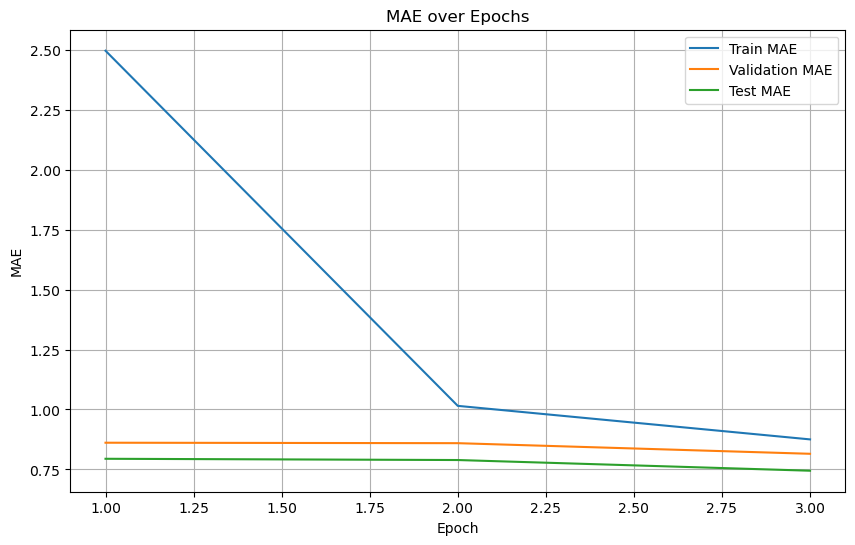

In [20]:
import torch
import os
import time
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, OneCycleLR, CosineAnnealingWarmRestarts
from tqdm import tqdm
import torch
from torch_geometric.data import InMemoryDataset, DataLoader
from torch.utils.data import Subset
from sklearn.utils import shuffle

class CustomDataset(InMemoryDataset):
    def __init__(self, path):
        super().__init__(path)
        self.data, self.slices = torch.load(path)
    
    def get_idx_split(self, data_size, train_size, valid_size, seed):
        ids = shuffle(range(data_size), random_state=seed)
        train_idx = torch.tensor(ids[:train_size])
        val_idx = torch.tensor(ids[train_size:train_size + valid_size])
        test_idx = torch.tensor(ids[train_size + valid_size:])
        return {'train': train_idx, 'valid': val_idx, 'test': test_idx}

# Load dataset
pt_file_path = '/mnt/c/Users/user/Desktop/DACON/LeftNet/temp/DACON22.pt'
dataset = CustomDataset(pt_file_path)

data_size = len(dataset)
train_size = int(0.8 * data_size)
valid_size = int(0.1 * data_size)
test_size = data_size - train_size - valid_size
split_dict = dataset.get_idx_split(data_size, train_size, valid_size, seed=42)

train_dataset = Subset(dataset, split_dict['train'])
valid_dataset = Subset(dataset, split_dict['valid'])
test_dataset = Subset(dataset, split_dict['test'])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

y_mean = torch.mean(dataset.data.y).item()
y_std = torch.std(dataset.data.y).item()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

model = LEFTNet(pos_require_grad=False, cutoff=5, num_layers=4, hidden_channels=256, 
                num_radial=32, y_mean=y_mean, y_std=y_std)
model = model.to(device)
loss_func = torch.nn.L1Loss()

optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=0)
scheduler = StepLR(optimizer, step_size=100, gamma=0.7)
scheduler_name = 'steplr'

save_dir = 'models/'
log_dir = ''

if save_dir != '':
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
if log_dir != '':
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir=log_dir)

num_params = sum(p.numel() for p in model.parameters())
disable_tqdm = False
best_valid = float('inf')
test_valid = float('inf')

# Store MAE for plotting
train_mae_list = []
valid_mae_list = []
test_mae_list = []

def train(model, optimizer, scheduler, scheduler_name, train_loader, loss_func, device, disable_tqdm):
    model.train()
    loss_accum = 0
    for step, batch_data in enumerate(tqdm(train_loader, disable=disable_tqdm)):
        optimizer.zero_grad()
        batch_data = batch_data.to(device)
        out = model(batch_data)
        loss = loss_func(out, batch_data.y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        if scheduler_name == 'onecyclelr':
            scheduler.step()
        loss_accum += loss.detach().cpu().item()
    return loss_accum / (step + 1)

def val(model, data_loader, device, disable_tqdm):
    model.eval()

    preds = torch.Tensor([]).to(device)
    targets = torch.Tensor([]).to(device)

    for step, batch_data in enumerate(tqdm(data_loader, disable=disable_tqdm)):
        batch_data = batch_data.to(device)
        with torch.no_grad():
            out = model(batch_data)
        preds = torch.cat([preds, out.detach_()], dim=0)
        targets = torch.cat([targets, batch_data.y.unsqueeze(1)], dim=0)

    return torch.mean(torch.abs(preds - targets)).cpu().item()

epochs = 400
start_epoch = 1

for epoch in range(start_epoch, epochs + 1):
    print("=====Epoch {}".format(epoch), flush=True)
    t_start = time.perf_counter()
    
    train_mae = train(model, optimizer, scheduler, scheduler_name, train_loader, loss_func, device, disable_tqdm=False)
    valid_mae = val(model, valid_loader, device, disable_tqdm)
    test_mae = val(model, test_loader, device, disable_tqdm)

    # Append MAE values for plotting
    train_mae_list.append(train_mae)
    valid_mae_list.append(valid_mae)
    test_mae_list.append(test_mae)

    if log_dir != '':
        writer.add_scalar('train_mae', train_mae, epoch)
        writer.add_scalar('valid_mae', valid_mae, epoch)
        writer.add_scalar('test_mae', test_mae, epoch)

    if valid_mae < best_valid:
        best_valid = valid_mae
        test_valid = test_mae
        if save_dir != '':
            print('Saving checkpoint...')
            checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'scheduler_state_dict': scheduler.state_dict(), 'best_valid_mae': best_valid, 'num_params': num_params}
            torch.save(checkpoint, os.path.join(save_dir, 'valid_checkpoint.pt'))

    t_end = time.perf_counter()
    print({'Train': train_mae, 'Validation': valid_mae, 'Test': test_mae, 'Best valid': best_valid, 'Test@ best valid': test_valid, 'Duration': t_end-t_start})

    if scheduler_name == 'steplr':
        scheduler.step()

# Save the final model
final_model_path = os.path.join(save_dir, 'final_model.pt')
torch.save(model.state_dict(), final_model_path)
print(f'Final model saved at {final_model_path}')

print(f'Best validation MAE so far: {best_valid}')
print(f'Test MAE when got best validation result: {test_valid}')

if log_dir != '':
    writer.close()

# Plot MAE for train, validation, and test
plt.figure(figsize=(10, 6))
plt.plot(range(start_epoch, epochs + 1), train_mae_list, label='Train MAE')
plt.plot(range(start_epoch, epochs + 1), valid_mae_list, label='Validation MAE')
plt.plot(range(start_epoch, epochs + 1), test_mae_list, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'mae_plot.png'))  # Save the plot
plt.show()



In [21]:
!pwd


/mnt/c/Users/user/Desktop/DACON/LeftNet
